#  Разработка модульного чат-бота с применением моделей 🤗 Transformers

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* https://huggingface.co/models?pipeline_tag=token-classification&sort=trending
* https://huggingface.co/docs/transformers/training
* https://github.com/seatgeek/thefuzz
* https://github.com/pytransitions/transitions
* https://github.com/gunthercox/ChatterBot
* https://deeppavlov.ai/

## Задачи для совместного разбора

1\. Рассмотрите типовые шаги для создания вопрос-ответного бота.

In [ ]:
db = {
    "film_director": {
        "Титаник": "Кэмерон",
        "Гибель «Титаника»": "Бейкер"
    }
}

In [ ]:
!pip install thefuzz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 9.0 MB/s eta 0:00:00


In [ ]:
from thefuzz import process

In [ ]:
question = "Кто режиссер Титаника"

def ner(question):
  return "Титаника"

def get_intent(question):
  return "film_director"

def get_answer(entity, intent):
  answers = db[intent]
  answer = process.extractOne(entity, answers.keys())
  return answer

In [ ]:
entity = ner(question)
print(entity)
intent = get_intent(question)
print(intent)
answer = get_answer(entity, intent)
print(answer)

Титаника
film_director
('Титаник', 93)


2\. Обсудите возможности пакета `transitions` для создания машины состояний бота.

In [ ]:
!pip install transitions

In [ ]:
from transitions import Machine
from random import randint


class Agent:
  states = ["start", "ner_success", "broken"]
  def __init__(self):
    self.machine = Machine(model=self, states=self.states, initial="start")

    self.machine.add_transition(
        trigger="do_ner",
        source="start",
        dest="ner_success",
        prepare="_do_ner",
        unless="broken"
    )

    self.machine.add_transition(
        trigger="do_ner",
        source="start",
        dest="broken",
        conditions="broken"
    )

    self.machine.add_transition(
        trigger="reset",
        # ...
        # ..
    )

    self.entity = None
    self._broken = False

  def _do_ner(self, question):
    self.entity = ner(question)
    if randint(0, 1) < 0.5:
      print("Машина сломалась")
      self._broken = True

  @property
  def broken(self):
    return self._broken

In [ ]:
agent = Agent()
print(agent.state)
agent.do_ner(question)
print(agent.state)

start
ner_success


In [ ]:
agent.entity

'Титаника'

## Задачи для самостоятельного решения

In [44]:
# !pip install datasets
# !pip install thefuzz
# !pip install transitions

In [47]:
from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import load_dataset
from thefuzz import process
from transitions import Machine
from random import randint
from google.colab import drive
drive.mount('/content/drive')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'cuda'

<p class="task" id="1"></p>

1\. Загрузите любую модель для распознавания именованных сущностей (NER) на русском языке из 🤗 Transformers. Напишите функцию `get_entity`. Продемонстрируйте пример работы на нескольких примерах из файлов с вопросами из каталога `qst_csv/questions`.

- [ ] Проверено на семинаре

In [3]:
def get_entity(question: str) -> dict:
    """
    Пример question: "Кто является оператором фильма Андеграунд"
    Возвращает словарь следующего вида
        {
            "score": 0.8,
            "word": "фильма Андеграунд",
        }

    """
    entities = pipe(question)
    score = entities[0]['score']
    word = []
    for entity in entities:
      word.append(entity['word'])
    word = ''.join(word)
    word = word.replace('▁', ' ').strip()
    return {'score': score, 'word': word}

In [4]:
pipe = pipeline("ner", model=AutoModelForTokenClassification.from_pretrained('denis-gordeev/rured2-ner-microsoft-mdeberta-v3-base'),
                tokenizer=AutoTokenizer.from_pretrained('denis-gordeev/rured2-ner-microsoft-mdeberta-v3-base'))
questions_dir = pd.read_csv('/content/drive/MyDrive/Учеба/nlp/06/qst_csv/qst_csv/questions/film_director.csv')
# answers_dir = pd.read_csv('/content/drive/MyDrive/Учеба/nlp/06/qst_csv/qst_csv/answers/film_director.csv')
for i in questions_dir['question'].head():
  print(i)
  print(get_entity(i))
  print('-------------------------')

config.json:   0%|          | 0.00/5.02k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Кто продюсировал Джон Уик
{'score': 0.998831, 'word': 'Джон Уик'}
-------------------------
Кто продюсировал фильм Балканский рубеж
{'score': 0.96319246, 'word': 'фильм Балканский рубеж'}
-------------------------
Кто продюсер фильма Мстители
{'score': 0.9999342, 'word': 'продюсер фильма Мстители'}
-------------------------
Кто продюсировал фильм Суспирия
{'score': 0.96656144, 'word': 'фильм Суспирия'}
-------------------------
Кто является продюсером фильма 50 оттенков серого
{'score': 0.9999486, 'word': 'продюсером фильма 50 оттенков серого'}
-------------------------


<p class="task" id="2"></p>

2\. Загрузите любую модель для классификации текста на русском языке из 🤗 Transformers. Дообучите эту модель для задачи предсказания трех классов: film_actors, film_cameraman и film_producer. При создании модели укажите маппинг индексов классов на названия.

Напишите функцию `get_intent`. Продемонстрируйте пример работы на нескольких примерах из файлов с вопросами из каталога `qst_csv/questions`.

- [ ] Проверено на семинаре

In [35]:
def tokenize(examples):
  return tokenizer(examples, return_tensors='pt', padding=True)

def get_intent(question: str) -> str:
    # Возвращает строку с интентом, например, film_cameraman
    tokens = tokenize(question)
    logits = model(input_ids=tokens['input_ids'].to(device), attention_mask=tokens['attention_mask'].to(device)).logits
    pred = logits.argmax(dim=-1).item()
    return id2label[pred]

In [6]:
paths = [
    '/content/drive/MyDrive/Учеба/nlp/06/qst_csv/qst_csv/questions/film_actors.csv',
    '/content/drive/MyDrive/Учеба/nlp/06/qst_csv/qst_csv/questions/film_cameraman.csv',
    '/content/drive/MyDrive/Учеба/nlp/06/qst_csv/qst_csv/questions/film_director.csv'
]
dfs = []
for i, path in enumerate(paths):
  df = pd.read_csv(path)
  df['class'] = i
  dfs.append(df)
data = pd.concat(dfs).reset_index(drop=True)
data.head()

,question,class
0,Кто сыграл в главных ролях Друзья,0
1,Кто в главных ролях Матрица,0
2,Кто играл главные роли в фильме Даун Хаус,0
3,Спартак актеры в главных ролях,0
4,Перечисли актеров которые играют главные роли ...,0


In [7]:
data.to_csv('/content/data.csv')

In [8]:
dataset = load_dataset('csv', data_files='/content/data.csv').remove_columns('Unnamed: 0')
dataset

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'class'],
        num_rows: 713
    })
})

In [9]:
tokenizer = AutoTokenizer.from_pretrained("m3hrdadfi/zabanshenas-roberta-base-mix", device=device)

dataset = dataset.map(tokenize, input_columns=['question'], batched=True, batch_size=1000)\
          .rename_column('class','labels')\
          .with_format("torch", columns=['input_ids', "labels", 'attention_mask'])\
          .remove_columns('question')
dataset

tokenizer_config.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/545k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/331k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/943k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Map:   0%|          | 0/713 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 713
    })
})

In [13]:
loader = DataLoader(dataset['train'], batch_size=16, shuffle=True)

id2label = {0: "film_actors",
            1: "film_cameraman",
            2: "film_director"}
label2id = dict(zip(id2label.values(), id2label.keys()))
model = AutoModelForSequenceClassification.from_pretrained("m3hrdadfi/zabanshenas-roberta-base-mix", ignore_mismatched_sizes=True, num_labels=3, id2label=id2label, label2id=label2id).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
n_epoch=10
model.train()
for epoch in range(n_epoch):
    losses = []
    for batch in tqdm(loader):
        out = model(input_ids=batch['input_ids'].to(device), attention_mask=batch['attention_mask'].to(device), labels=batch['labels'].to(device))

        out.loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        losses.append(out.loss)
    print(f'Epoch_{epoch+1}: loss = {torch.mean(torch.tensor(losses))}')

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at m3hrdadfi/zabanshenas-roberta-base-mix and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([235, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([235]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 45/45 [00:05<00:00,  8.79it/s]


Epoch_1: loss = 0.18401676416397095


100%|██████████| 45/45 [00:05<00:00,  8.68it/s]


Epoch_2: loss = 0.02781771309673786


100%|██████████| 45/45 [00:05<00:00,  8.46it/s]


Epoch_3: loss = 0.024083249270915985


100%|██████████| 45/45 [00:05<00:00,  8.05it/s]


Epoch_4: loss = 0.07467072457075119


100%|██████████| 45/45 [00:05<00:00,  7.80it/s]


Epoch_5: loss = 0.05121693015098572


100%|██████████| 45/45 [00:05<00:00,  8.34it/s]


Epoch_6: loss = 0.20250020921230316


100%|██████████| 45/45 [00:05<00:00,  8.40it/s]


Epoch_7: loss = 0.010474137030541897


100%|██████████| 45/45 [00:05<00:00,  8.30it/s]


Epoch_8: loss = 0.009249021299183369


100%|██████████| 45/45 [00:05<00:00,  8.18it/s]


Epoch_9: loss = 0.007365945260971785


100%|██████████| 45/45 [00:05<00:00,  8.08it/s]

Epoch_10: loss = 0.05035219341516495


In [14]:
test_data = data.sample(10)
test_data

,question,class
391,Кто оператор фильма Убить Билла,1
173,Кто сыграл главные роли в фильме Место встречи...,0
202,Кто является оператором комедии Иван Васильеви...,1
233,Кто был оператором в фильме Призрачный атлас,1
69,Кто играл второстепенные роли в фильме Щелкунч...,0
42,имена людей сыгравших в главных ролях фильме д...,0
586,Подскажите фамилию продюсера киноленты Операци...,2
260,Кто оператор фильма Стекло,1
430,Кто является оператором фильма Бегущий по лезв...,1
16,Кто сыграл главные роли в фильме 11,0


In [36]:
for q, c in test_data.values:
  print(q)
  print(f'pred_label: {get_intent(q)}')
  print(f'true_label: {id2label[c]}')
  print('------------')

Кто оператор фильма Убить Билла
pred_label: film_cameraman
true_label: film_cameraman
------------
Кто сыграл главные роли в фильме Место встречи изменить нельзя
pred_label: film_actors
true_label: film_actors
------------
Кто является оператором комедии Иван Васильевич меняет профессию
pred_label: film_cameraman
true_label: film_cameraman
------------
Кто был оператором в фильме Призрачный атлас
pred_label: film_cameraman
true_label: film_cameraman
------------
Кто играл второстепенные роли в фильме Щелкунчик и четыре королевства
pred_label: film_actors
true_label: film_actors
------------
имена людей сыгравших в главных ролях фильме доктор Джекилл и мисс Хайд
pred_label: film_actors
true_label: film_actors
------------
Подскажите фамилию продюсера киноленты Операция Ы и другие приключения Шурика
pred_label: film_director
true_label: film_director
------------
Кто оператор фильма Стекло
pred_label: film_cameraman
true_label: film_cameraman
------------
Кто является оператором фильма Б

<p class="task" id="3"></p>

3\. Создайте словарь `db` следующего вида:
```
{
    "film_director": {
        "Т 34": "Алексей Сидоров (Aleksey Sidorov)",
        "Матч": "Андрей Малюков (Andrey Malyukov)",
        ...
    },
    ...
}
```

Напишите функцию `find_answer`. Продемонстрируйте работоспособность на нескольких примерах.

- [ ] Проверено на семинаре

In [16]:
film_actors_ans = pd.read_csv('/content/drive/MyDrive/Учеба/nlp/06/qst_csv/qst_csv/answers/film_actors.csv')
film_cameraman_ans = pd.read_csv('/content/drive/MyDrive/Учеба/nlp/06/qst_csv/qst_csv/answers/film_cameraman.csv')
film_director_ans = pd.read_csv('/content/drive/MyDrive/Учеба/nlp/06/qst_csv/qst_csv/answers/film_director.csv')

In [40]:
db = {
    'film_actors': dict(film_actors_ans.values),
    'film_cameraman': dict(film_cameraman_ans.values),
    'film_director': dict(film_director_ans.values),
}

In [41]:
def find_answer(entity: str, intent: str, db: dict) -> tuple[str, int]:
    """entity - результат работы get_entity,intent - результат работы get_intent
    Для поиска ключа в словаре db[intent] воспользуйтесь методом process.extractOne из пакета thefuzz
    """
    answers = db[intent]
    if entity != '':
        answer = process.extractOne(entity, answers.keys())
        return {'answer': answers[answer[0]], 'score': answer[1]}
    return {'answer': '', 'score': 0}

In [42]:
for sen in test_data['question']:
    entity = get_entity(sen)
    intent = get_intent(sen)
    print(sen)
    print('entity:', entity)
    print('intent:', intent)
    print('answer:', find_answer(entity['word'], intent, db))
    print()

Кто оператор фильма Убить Билла
entity: {'score': 0.99961144, 'word': 'оператор фильм Убить Билла'}
intent: film_cameraman
answer: {'answer': 'Эндрю Шульц (Andrew Schultz)', 'score': 60}

Кто сыграл главные роли в фильме Место встречи изменить нельзя
entity: {'score': 0.5000814, 'word': 'Место встречи изменить нельзя'}
intent: film_actors
answer: {'answer': 'Владимир Высоцкий, Евгений Леонов', 'score': 100}

Кто является оператором комедии Иван Васильевич меняет профессию
entity: {'score': 0.99995387, 'word': 'оператором комедии Иван Васильевич меняет профессию'}
intent: film_cameraman
answer: {'answer': 'Вадим Юсов (Vadim Yusov)', 'score': 90}

Кто был оператором в фильме Призрачный атлас
entity: {'score': 0.999705, 'word': 'оператором в фильме Призрачный атлас'}
intent: film_cameraman
answer: {'answer': 'Майкл Бонвилл (Michael Bonvill)', 'score': 86}

Кто играл второстепенные роли в фильме Щелкунчик и четыре королевства
entity: {'score': 0.88134116, 'word': 'фильме Щелкунчик и четыре

<p class="task" id="4"></p>

4\. Используя пакет `transitions`, опишите машину состояний следующего вида:

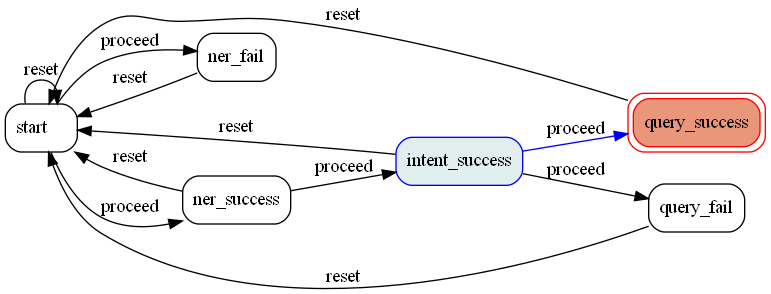

Реализуйте агента для ответов на вопросы по кино. Логика работы агента должна быть следующая:
* начинает в состоянии start;
* при вызове метода `proceed` в состоянии `start` вызывает `find_entity`, переходит в состояние `ner_success` и сохраняет найденное значение в виде атрибута `self.entity`, если сущность найдена, и переходит в `ner_fail` в противном случае;
* при вызове метода `proceed` в состоянии `ner_success` вызывает `find_intent`, переходит в состояние `intent_success` и сохраняет найденное значение в виде атрибута `self.intent`;
* при вызове метода `proceed` в состоянии `intent_success` вызывает `find_answer`, переходит в состояние `query_success` и сохраняет найденное значение в виде атрибута `self.answer`, если сущность найдена, и переходит в `query_fail` в противном случае;
* при вызове метода `reset` в любом состоянии переход в начальное состояние с сбрасывает значения атрибутов `self.entity`, `self.intent` и `self.answer`.

Если `find_entity` возвращает пустой результат или `score` меньше 0.3, то считайте, что сущность не найдена. Если find_answer возвращает score меньше 50, то считайте, что сущность не найдена.

Продемонстрируйте примеры работы агента.

- [ ] Проверено на семинаре

In [77]:
class Agent:
    def __init__(self, db):
        self.db = db
        self.entity = ''
        self.intent = ''
        self.answer = ''
        self.machine = Machine(model=self, states=['start', 'ner_success', 'ner_fail', 'intent_success', 'query_fail', 'query_success'], initial='start')

        self.machine.add_transition(
            trigger='proceed',
            source='start',
            dest='ner_success',
            prepare='_do_ner',
            conditions=['_yes_entity'])

        self.machine.add_transition(
            trigger='proceed',
            source='start',
            dest='ner_fail',
            prepare='_do_ner',
            conditions=['_no_entity'])

        self.machine.add_transition(
            trigger='proceed',
            source='ner_success',
            dest='intent_success',
            prepare='_find_intent')

        self.machine.add_transition(
            trigger='proceed',
            source='intent_success',
            dest='query_fail',
            prepare='_find_answer',
            conditions=['_no_answer'])

        self.machine.add_transition(
            trigger='proceed',
            source='intent_success',
            dest='query_success',
            prepare='_find_answer',
            conditions=['_yes_answer'])

        self.machine.add_transition(
            trigger='reset',
            source='*',
            dest='start',
            after='_reset_attributes'
        )

    def _do_ner(self, question):
        self.entity = get_entity(question)
        self.question = question

    def _yes_entity(self, question):
        if self.entity:
          return self.entity['score'] >= 0.3
        else: return False

    def _no_entity(self, question):
        return self.entity == [] or self.entity['score'] < 0.3

    def _find_intent(self):
        self.intent = get_intent(self.question)
        # print(self.entity)

    def _find_answer(self):

        self.answer = find_answer(self.entity['word'], intent=self.intent, db=self.db)
        print(self.answer)

    def _yes_answer(self):
        return self.answer['score'] >= 50

    def _no_answer(self):
        return self.answer['score'] < 50

    def _reset_attributes(self):
        self.entity = ''
        self.intent = ''
        self.answer = ''

In [76]:
agent = Agent(db)
agent.reset()
print(agent.state)
print(agent.entity,agent.intent,agent.answer)
agent.proceed(test_data['question'].values[0])
print(agent.state)
print(agent.entity,agent.intent,agent.answer)
agent.proceed()
print(agent.state)
print(agent.entity,agent.intent,agent.answer)
agent.proceed()
print(agent.state)
print(agent.entity,agent.intent,agent.answer)

start
  
ner_success
{'score': 0.99961144, 'word': 'оператор фильм Убить Билла'}  
intent_success
{'score': 0.99961144, 'word': 'оператор фильм Убить Билла'} film_cameraman 
{'answer': 'Эндрю Шульц (Andrew Schultz)', 'score': 60}
{'answer': 'Эндрю Шульц (Andrew Schultz)', 'score': 60}
query_success
{'score': 0.99961144, 'word': 'оператор фильм Убить Билла'} film_cameraman {'answer': 'Эндрю Шульц (Andrew Schultz)', 'score': 60}


In [78]:
agent.reset()
print(agent.state)
print(agent.entity,agent.intent,agent.answer)
agent.proceed(question='Акетры NLP1337')
print(agent.state)
print(agent.entity,agent.intent,agent.answer)
agent.proceed()
print(agent.state)
print(agent.entity,agent.intent,agent.answer)
agent.proceed()
print(agent.state)
print(agent.entity,agent.intent,agent.answer)

start
  
ner_success
{'score': 0.6358389, 'word': 'NLP1337'}  
intent_success
{'score': 0.6358389, 'word': 'NLP1337'} film_cameraman 
{'answer': 'Максим Осадчий (Maksym Osadchiy)', 'score': 45}
query_fail
{'score': 0.6358389, 'word': 'NLP1337'} film_cameraman {'answer': 'Максим Осадчий (Maksym Osadchiy)', 'score': 45}


## Обратная связь
- [ ] Хочу получить обратную связь по решению